# RDI sensitivity

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
import sys
import os

folder = '../../../../crispy'
print(folder)
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)

from crispy.tools.initLogger import getLogger
log = getLogger('crispy')
from crispy.IFS import polychromeIFS
from crispy.IFS import reduceIFSMap
from crispy.tools.imgtools import scale2imgs,bowtie
from crispy.tools.image import Image
from crispy.tools.rotate import rotateCube,shiftCube
from crispy.tools.postprocessing import mf,recenter_offaxis
from crispy.tools.inputScene import adjust_krist_header
from crispy.tools.detector import averageDetectorReadout
from astropy.io import fits
import astropy.units as u
from crispy.tools.postprocessing import construct_mflib,convolved_mf



Populating the interactive namespace from numpy and matplotlib
../../../../crispy


## Parameters

In [2]:
lamc=660.
BW = 0.18
par.nonoise=True
sampling=2.2
par.lenslet_sampling=1./sampling
folder = '/Users/mrizzo/IFS/OS5_RDI_660_'+str(sampling)
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
OS5_files = '/Users/mrizzo/IFS/OS5/with_lowfc/'
# folder = '/local/data/nicolaus2/mrizzo/OS5_RDI_660_'+str(sampling)
# offaxis_psf_filename='/local/data/nicolaus2/mrizzo/haystacks/for_gsfc/spc_offaxis_psf.fits'
# OS5_files = '/local/data/nicolaus2/mrizzo/haystacks/for_gsfc/with_lowfc/'
IWA=2.7
OWA=8.7
try:
    os.makedirs(folder)
    os.makedirs(folder+'/average')
    os.makedirs(folder+'/detector')  
except OSError:
    pass
par.hdr


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT                                                                         
COMMENT ************************************************************            
COMMENT ********************** General parameters ******************            
COMMENT ************************************************************            
COMMENT                                                                         
NLENS   =                  108 / # lenslets across array                        
PITCH   =             0.000174 / Lenslet pitch (meters)                         
INTERLAC=                    2 / Interlacing                                    
PHILENS =    26.565051177077

## Process all files from Krist

Only need to do this the first time

In [3]:
from crispy.tools.postprocessing import processReferenceCubes,processTargetCubes
import astropy.units as u
import glob
filelist = glob.glob(OS5_files+'*.fits')
filelist.sort()
Nref=30
reffiles = filelist[:Nref]
targetfiles =filelist[Nref:]

# ref_outlist = processReferenceCubes(par,xshift=0.0,yshift=0.0,order=3,
#                 outdir_time_series = folder,
#                 ref_input_list=reffiles,
#                 ref_star_T=9377*u.K, ref_star_Vmag=2.37,
#                 lamc=lamc,BW = BW,
#                 tel_pupil_area=3.650265060424805*u.m**2)
# target_outlist = processTargetCubes(par,target_file_list=targetfiles,
#                 outdir_time_series = folder,
#                 target_star_T=5887*u.K, target_star_Vmag=5.03,
#                 lamc=lamc,BW = BW,
#                 tel_pupil_area=3.650265060424805*u.m**2)


## Process the offaxis as a poke to normalize contrast

This constructs the file outdir_average+"/offaxis.fits"

In [4]:
file_for_shape = Image(OS5_files+'os5_spc_001.fits').data
fileshape = file_for_shape.shape
Nlam = fileshape[0]
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,Nlam)*u.nm
from crispy.tools.postprocessing import process_offaxis
process_offaxis(par,offaxis_psf_filename=offaxis_psf_filename,
                fileshape=fileshape,
                lamlist=lamlist,
                lamc=lamc,
                outdir_average=folder+'/average',
                target_star_T=5887*u.K, target_star_Vmag=5.03,
                tel_pupil_area=3.650265060424805*u.m**2)

plt.figure(figsize=(12,12))
img=Image(folder+'/average/offaxis.fits').data
plt.imshow(img,cmap='Greys_r')
plt.colorbar()



crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
Processing file /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits


KeyboardInterrupt: 

## Construct matched filter library

In [3]:
offaxis_reduced = Image(folder+"/average/offaxis_detector_red_optext.fits")

ydim,xdim = offaxis_reduced.data[0].shape
mask,scratch = bowtie(offaxis_reduced.data[0],ydim//2-1,xdim//2,openingAngle=60,
        clocking=-par.philens*180./np.pi,
        IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
        export=None,twomasks=False)    


crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/offaxis_detector_red_optext.fits


In [4]:
from crispy.tools.postprocessing import construct_mflib


construct_mflib(par,folder+"/average/offaxis_detector_red_optext.fits",
                threshold=0.2,
                lamc=lamc,
                BW=BW,
                outdir=folder+'/average/',
                mask=mask,
                trim=30,
                outname = 'mflib.fits.gz',
                order=3)



crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/offaxis_detector_red_optext.fits
crispy - INFO - Coordinates of the planet in lenslets: 67.00, 47.00


## Run RDI

In [4]:
from crispy.tools.postprocessing import RDI_noise


offset = [0.5,0.0]

results = np.zeros((19,len(offset),len(offset)))
for i in range(len(offset)):
    for j in range(len(offset)):

        rootname='x%.2f_y%.2f' % (offset[i],offset[j])
        try:
            os.makedirs(folder+'/average/'+rootname)
        except OSError:
            pass

        results[:,i,j] = RDI_noise(par,offset[i],offset[j],order=3,
                rootname=rootname,
                process_cubes=False,
                countershift=True,
                normalize_contrast=True,
                ref_only=True,
                IWA=IWA,
                OWA=OWA,
                outdir_time_series = folder,
                outdir_detector=folder+'/detector',
                outdir_average=folder+'/average/'+rootname,
                psf_time_series_folder=OS5_files,
                offaxis_psf_filename=offaxis_psf_filename,
                mflib = folder+'/average/mflib.fits.gz',
                lamc=lamc,BW=BW,
                offaxis_reduced = folder+'/average/offaxis_detector_red_optext.fits')
outkey = fits.HDUList(fits.PrimaryHDU(results.astype(np.float)))
outkey.writeto(folder+'/average/results_rdi'+str(sampling)+'.fits',clobber=True)


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - X,Y Shift in px in original cubes: 2.27, 2.27
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Taking average of reference star
crispy - INFO - Apply detector readout on os5_spc_001_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/os5_spc_001_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI_660_2.2/detector/os5_spc_001_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_002_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/os5_spc_002_refstar_IFS.fits
crispy - INFO - Writing data to /Users/mrizzo/IFS/OS5_RDI_660_2.2/detector/os5_spc_002_refstar_IFS_detector.fits
crispy - INFO - Apply detector readout on os5_spc_003_refstar_IFS.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RD

crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/results_rdi2.2.fits


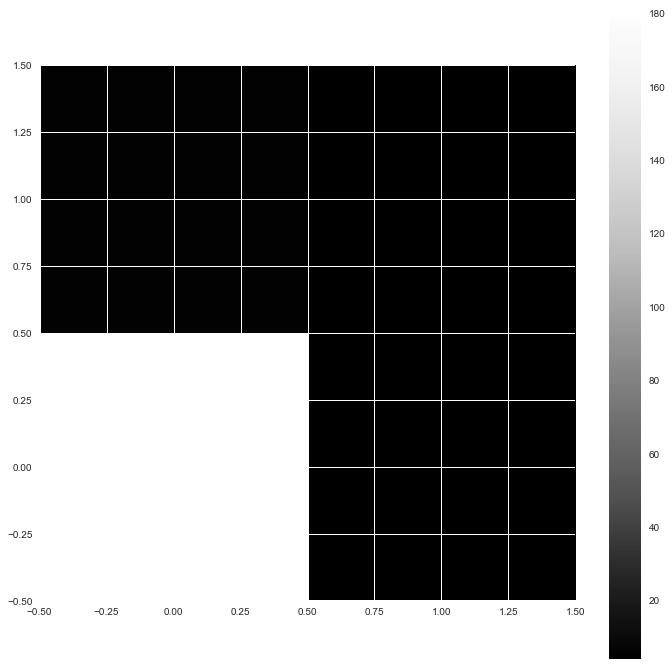

In [5]:
plt.figure(figsize=(12,12))
results=Image(folder+'/average/results_rdi'+str(sampling)+'.fits').data
plt.imshow(results[10],cmap='Greys_r')
plt.colorbar()

In [4]:
target = Image(folder+'/average/'+rootname+'/target_average_detector_red_optext.fits')
ref = Image(folder+'/average/'+rootname+'/ref_average_detector_countershifted_x0.50_y0.50_red_optext.fits')
ydim,xdim = target.data[0].shape
print ydim,xdim
bowtie_mask,scratch = bowtie(target.data[0],ydim//2-1,xdim//2,openingAngle=60,
            clocking=-par.philens*180./np.pi,
            IWApix=IWA*lamc/par.lenslet_wav/par.lenslet_sampling,
            OWApix=OWA*lamc/par.lenslet_wav/par.lenslet_sampling,
            export=None,twomasks=False)    

from crispy.tools.imgtools import scale2imgs
coefs,residual = scale2imgs(target,ref,bowtie_mask,returndiff = True)
print(coefs)

crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/x0.50_y0.50/target_average_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/x0.50_y0.50/target_average_detector_red_optext.fits
crispy - INFO - Read data from HDU 1 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/x0.50_y0.50/ref_average_detector_countershifted_x0.50_y0.50_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of /Users/mrizzo/IFS/OS5_RDI_660_2.2/average/x0.50_y0.50/ref_average_detector_countershifted_x0.50_y0.50_red_optext.fits
108 108
[[  8.03885767e-02   3.26590124e-01]
 [  3.12890862e-02   3.31495646e-01]
 [ -1.09108720e-01   3.39879292e-01]
 [ -4.95404454e-02   3.43365433e-01]
 [  3.01160359e-02   3.45862470e-01]
 [  8.56918136e-02   3.48948649e-01]
 [  1.04052770e-01   3.53022682e-01]
 [  8.50419221e-02   3.58020413e-01]
 [  4.23309772e-02   3.63871224e-01]
 [  1.30308952e-02   3.69566236e-01]
 [  1.13641421

In [7]:
10**(0.4*(5.03-2.36))

11.694993910198717